In [99]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()

using DifferentialEquations, PyPlot, Statistics

defaultcolors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

Activating environment at `~/Projects/DynamicPopulations/Project.toml`


10-element Array{String,1}:
 "#1f77b4"
 "#ff7f0e"
 "#2ca02c"
 "#d62728"
 "#9467bd"
 "#8c564b"
 "#e377c2"
 "#7f7f7f"
 "#bcbd22"
 "#17becf"

In [111]:
struct Network{A}
    transmission_rate :: A
    edges :: A
end

Network(N; transmission_rate=0.1, edges=1) = Network(transmission_rate .* ones(N, N), edges .* ones(N, N))

struct Infection{T}
    pressure :: T # Infectious pressure on node i
    recovery :: T # Recovery rate of node i
end

Infection(N; recovery_rate=0.1) = Infection(zeros(N), recovery_rate .* ones(N))

Parameters(N; transmission_rate=0.1, recovery_rate=0.1, edges=1) = 
    (      network = Network(N, transmission_rate=transmission_rate),
         infection = Infection(N, recovery_rate=recovery_rate),
     scratch_space = zeros(N, N),
        population = N
    )

Parameters (generic function with 3 methods)

In [112]:
function network_SIR!(dstates, states, parameters, time)
    S = view(states, 1, :)
    I = view(states, 2, :)
    
    @. parameters.scratch_space = parameters.network.edges * parameters.network.transmission_rate
    
    parameters.infection.pressure .= parameters.scratch_space * I
    
    @views @. dstates[1, :] = - parameters.infection.pressure * S
    @views @. dstates[2, :] = parameters.infection.pressure * S - parameters.infection.recovery * I
end

function extract(solution)
    nt = length(solution.t)
    N = solution.prob.p.population
    S = zeros(N, nt)
    I = zeros(N, nt)

    for j = 1:nt
        for i = 1:N
            S[i, j] = solution.u[j][1, i]
            I[i, j] = solution.u[j][2, i]
        end
    end
    
    R = @. N - S - I

    return solution.t, S, I, R
end

extract (generic function with 1 method)

In [121]:
N = 100
parameters = Parameters(N, recovery_rate=0.01, edges=identity(N, N))

initial_state = zeros(2, N)
initial_state[2, :] .= 0.1 * rand(N)           # Sprinkle some infected people around
initial_state[1, :] .= N .- initial_state[2, :] # Nobody is recovered.

problem = ODEProblem(network_sir!, initial_state, (0.0, 400.0), parameters)
solution = solve(problem);

MethodError: MethodError: no method matching identity(::Int64, ::Int64)
Closest candidates are:
  identity(::Any) at operators.jl:502

In [122]:
propertynames(solution.prob.p)

(:network, :infection, :scratch_space, :population)

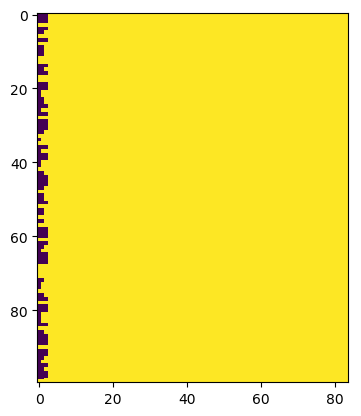

PyObject <matplotlib.image.AxesImage object at 0x1be70e320>

In [118]:
t, S, I, R = extract(solution)

imshow(log10.(I))